<a href="https://colab.research.google.com/github/timothy-hister/tweet-classification-nn/blob/main/Classifying_Disaster_Related_Tweets_as_Real_or_Fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, I will build a deep learning text classification model that predicts which Tweets are about real disasters and which aren't. The dataset comes from Kaggle.

# Setup

In this section, we'll import libraries and install packages, get the data, and do some initial investigations of it.

## Install and import

In [42]:
# Imports

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

from plotnine import *
import random

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

from functools import reduce
import operator

from wordcloud import WordCloud

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from transformers import AutoTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
%%capture
!pip install datasets
!pip install transformers

In [3]:
%%capture

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Explore Data

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [10]:
train.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

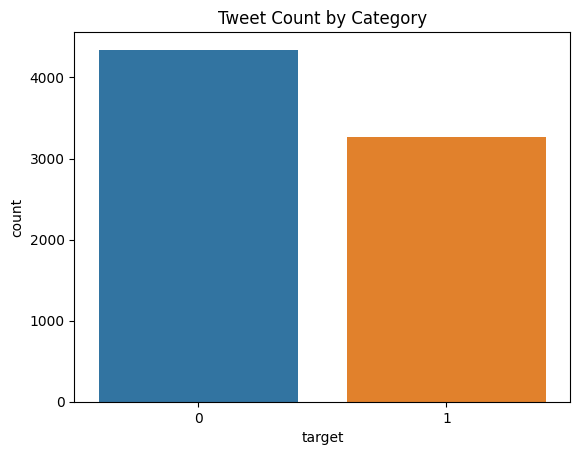

In [13]:
sns.countplot(x='target', data = train)
plt.title('Tweet Count by Category')
plt.show()

Most tweets are not about disasters, as we might expect. Also, location and keyword don't really help, so we drop them.

In [11]:
train = train[['text', 'target']]

# Text Preprocessing

In this section, we'll convert strings to lowercase, get rid of punctuation, tokenize words, get rid of 'stop' words, and 'lemmatize' words (for consistency).

In [14]:
train['text'] = train['text'].str.lower()
train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [15]:
train['text'] = train['text'].apply(lambda s: re.sub(r'[^\w\s]', ' ', s))
train['text'].head()

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3    13 000 people receive  wildfires evacuation or...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

In [16]:
train['text'] = train['text'].apply(lambda word: word_tokenize(word))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [13, 000, people, receive, wildfires, evacuati...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [17]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.add('br')
stop_words.add('http')
stop_words.add('https')
stop_words.add('co')

train['text'] = train['text'].apply(lambda l: [word for word in l if word not in stop_words])
train['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13, 000, people, receive, wildfires, evacuati...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [18]:
lemmatizer = WordNetLemmatizer()
train['text'] = train['text'].apply(lambda s: [lemmatizer.lemmatize(word=word, pos='v') for word in s])
train['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, ask, shelter, place, notify, offic...
3    [13, 000, people, receive, wildfires, evacuati...
4    [get, send, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [20]:
all_disaster_tweets = ' '.join(reduce(operator.concat, train['text'][train['target'] == 1]))
all_nondisaster_tweets = ' '.join(reduce(operator.concat, train['text'][train['target'] == 0]))

# Word Clouds

We'll print two 'word clouds' using the processed train data, one for disaster related tweets and one for not-disaster related tweets.

In [21]:
word_cloud_disaster = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(all_disaster_tweets)
word_cloud_nondisaster = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(all_nondisaster_tweets)

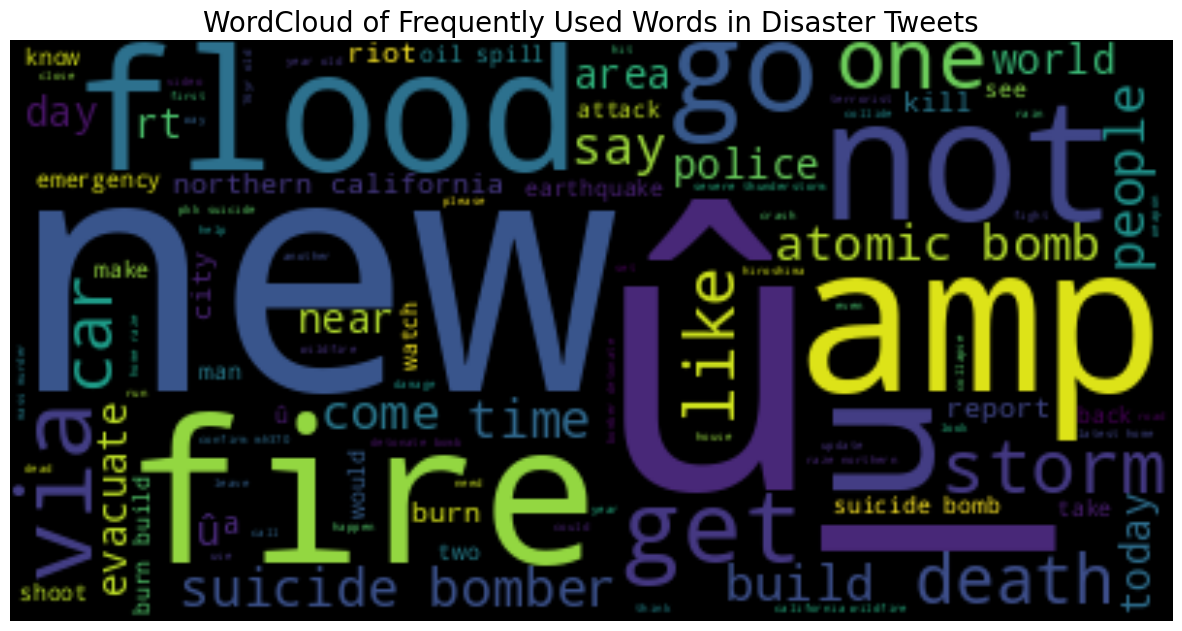

In [22]:
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_disaster, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Disaster Tweets', fontsize=20)
plt.axis("off")
plt.show()

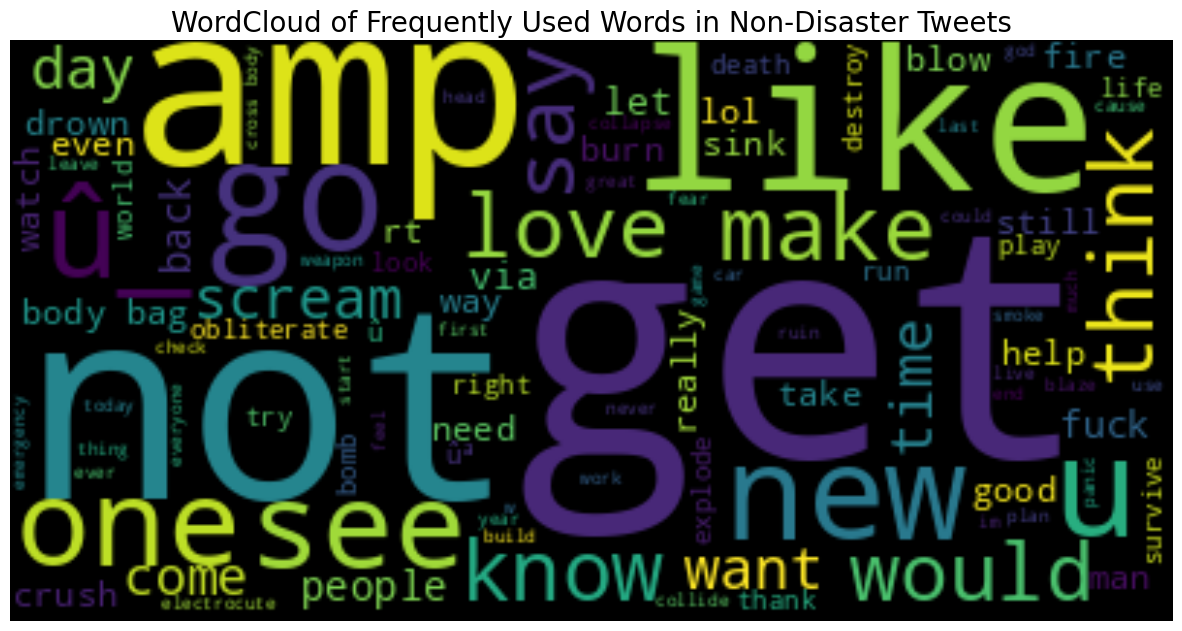

In [23]:
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_nondisaster, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Non-Disaster Tweets', fontsize=20)
plt.axis("off")
plt.show()

It is evident that there is some sort of effect. We can see words like "atomic bomb" in the disaster tweets at a higher rate than in the non-disaster tweets. Unsurprisingly, the majority of tweets, whether disaster-related or not, consist mostly of 'neutral' words like 'not.'

# Neural Networks

In this section, we'll build a series of neural networks that attempt to classify tweets. We'll track accuracy as the evaluation metric of model performance.

## Hyperparameters

In [25]:
epochs = 20
verbosity = 2
optimizer = Adam(learning_rate=.0001)
loss = 'binary_crossentropy'
metrics = ['accuracy']
dropout = .1
max_tokens = 20000
output_sequence_length = 256
output_dim = 128

## Helper Function

In [26]:
accuracies = []

def model_print(model):
  train_loss, train_acc = model.evaluate(train_X, train_y)
  val_loss, val_acc = model.evaluate(val_X, val_y)
  print(f"\nTrain set accuracy: {round(train_acc, 2)}; Validation set accuracy: {round(val_acc, 2)}")
  accuracies.append({'train': round(train_acc, 2), 'val': round(val_acc, 2)})

## Process Data

In [27]:
test_X = test['text'].apply(' '.join)

train_X = train['text'].apply(' '.join)
train_y = np.array(train['target'], dtype='int')
train_y = train['target']

val_idx = random.sample(range(train_X.shape[0]), int(train_X.shape[0]*.2))
train_idx = list(set(range(train_X.shape[0])) - set(val_idx))

assert len(val_idx + train_idx) == train_X.shape[0]

val_X = train_X[val_idx]
val_y = train_y[val_idx]
train_X = train_X[train_idx]
train_y = train_y[train_idx]

print(val_X.shape, val_y.shape, train_X.shape, train_y.shape)

(1522,) (1522,) (6091,) (6091,)


In [28]:
vectorizer_layer = TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    standardize = 'lower_and_strip_punctuation',
    output_sequence_length = output_sequence_length)

vectorizer_layer.adapt(train_X)

In [29]:
embedding_layer = Embedding(
    input_dim = max_tokens,
    output_dim = output_dim,
    input_length = output_sequence_length)

## Shallow Network

The first model is simple: a vectorizing layer, embedding layer and a final softmax layer for binary classification.

In [30]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

model.fit(train_X, train_y, epochs=epochs, verbose=verbosity)
model_results = model_print(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 128)          2560000   
                                                                 
 dense (Dense)               (None, 256, 1)            129       
                                                                 
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
191/191 - 2s - loss: 0.6872 - accuracy: 0.5702 - 2s/epoch - 11ms/step
Epoch 2/20
191/191 - 1s - loss: 0.6837 - accuracy: 0.5740 - 815ms/epoch - 4ms/step
Epoch 3/20
191/191 - 1s - loss: 0.6828 - accuracy: 0.5761 - 823ms/epoch - 4ms/st

Pretty crappy accuracy, but that's not surprising considering the simplicity of our model thus far.

## Deep Neural Network

Here, we add a number of dense layers as well as a dropout layer in the middle of the network.

In [31]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
[model.add(Dense(2**i, activation='relu', kernel_regularizer=L1L2(0.0005))) for i in range(7, 2, -1)] # add dense layers with decreasing factor of two nodes
model.add(Dropout(rate=dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()
model.fit(train_X, train_y, epochs=epochs, verbose=verbosity)

model_print(model)
print(f"Previous model accuracy: {accuracies[-2]}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 128)          2560000   
                                                                 
 dense_1 (Dense)             (None, 256, 128)          16512     
                                                                 
 dense_2 (Dense)             (None, 256, 64)           8256      
                                                                 
 dense_3 (Dense)             (None, 256, 32)           2080      
                                                                 
 dense_4 (Dense)             (None, 256, 16)           528       
                                                      

Accuracy has basically stayed the same with addition of the dense and dropout layers.

## Deep NN with LSTMS

The next model makes use of bidirectional LSTMS.

In [32]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
[model.add(Dense(2**i, activation='relu', kernel_regularizer=L1L2(0.0005))) for i in range(7, 2, -1)] # add dense layers with decreasing factor of two nodes
model.add(Dropout(rate=dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()
model.fit(train_X, train_y, epochs=epochs, verbose=verbosity)

model_print(model)
print(f"Previous model accuracy: {accuracies[-2]}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                 

## Model with Transformers

The final model uses transformers. (Note that some of the processing and parameters are slightly different from the previous models.)

In [33]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [34]:
train_encodings = tokenizer(list(train_X), max_length=128, truncation=True, padding=True)
val_encodings = tokenizer(list(val_X), max_length=128, truncation=True, padding=True)
test_encodings = tokenizer(list(test_X), max_length=128, truncation=True, padding=True)

In [35]:
train_data = tf.data.Dataset.from_tensor_slices((dict(train_encodings), tf.constant(train_y, dtype=tf.int32)))
train_data = train_data.shuffle(len(train_X)).batch(16)

val_data = tf.data.Dataset.from_tensor_slices((dict(val_encodings), tf.constant(val_y, dtype=tf.int32)))
val_data = val_data.batch(16)

In [36]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model.summary()
model.fit(train_data, epochs=epochs, verbose=verbosity)
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
print(f"\nTrain set accuracy: {round(train_acc, 2)}; Validation set accuracy: {round(val_acc, 2)}")
accuracies.append({'train': round(train_acc, 2), 'val': round(val_acc, 2)})
print(f"Previous model accuracy: {accuracies[-2]}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
381/381 - 80s - loss: 0.4637 - accuracy: 0.7920 - 80s/epoch - 210ms

# Conclusion

In [37]:
accuracies

[{'train': 0.58, 'val': 0.58},
 {'train': 0.57, 'val': 0.57},
 {'train': 1.0, 'val': 0.76},
 {'train': 1.0, 'val': 0.82}]

The model that performed best was the final one, the model that used transformers. In further iterations, we can experiment with different hyperparameters and model design.